# Bayesian Updating: Posterior Return Probabilities
In this notebook, we explore Bayesian updating related to market regime probabilities. Part 1 covers an expanding approach and Part 2 covers a windowed approach.

### Overview
The future regime of the stock market is a binary outcome, either positive or negative. Because of this fact, future market regimes are analogous to a ***biased*** coin flip with an unknown probability of heads (positive regime). If we have an initial assumption about the behavior of market regimes, we can apply the Bayesian updating process to ***learn*** the probability of a positive regime.

Suppose we are given a price time-series $P_{t}$. The daily return series, $R_{t}$, is<br>
$R_{t}=\frac{P_{t}-P_{t-1}}{P_{t-1}}$

Given the return series $R_{t}$, the market regime, $M_{t}$, is<br>
$
M_{t}=\begin{cases}
\text{1} & \text{if } R_{t} > 0 \\
\text{0} & \text{if } R_{t} \le 0
\end{cases}
$

As we can see, $M_{t} \sim \text{Bernoulli}(p)$, where $p$ is the unknown probability of a positive regime. The objective is to define the Bayesian updating process such that we can infer $p$ as we make new market return observations.<br>
$p \exists [0, 1]$

$p$ itself is a continuous random variable. Because of this, $p$ has a conjugate prior drawn from a $Beta$ distribution. Specifically,<br>
$p \sim \text{Beta}(\alpha, \beta)$

where $\alpha > 0$ and $\beta > 0$

The probability density function is defined as<br>
$p(X=x)=\frac{x^{\alpha-1}(1-x)^{\beta-1}}{B(\alpha, \beta)}$

Where $B(\alpha,\beta)=\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha+\beta)}$

Where $\Gamma(t)=\int_{0}^{\infty} e^{-x}x^{t-1}dx$

The expected value of a $Beta$ random variable is<br>
$E[X]=\frac{\alpha}{\alpha+\beta}$

To ***learn*** the value of $p$ as we make daily return observations, we must start with an initial assumption regarding the parameters of the conjugate prior, also known as hyperparameters. Because $p$ is the parameter of the $Bernoulli$ distribution, and drawn from a $Beta$ distribution, we must set inital values for $\alpha$ and $\beta$.<br>
$\alpha$ represents the positive regimes<br>
$\beta$ represents the negative regimes

We start with a uniform assumption between positive and negative regimes. That is $\alpha=1$, $\beta=1$. Because $p$ is drawn from a $Beta$ distribution,<br>
$\~{p}=E[p]=\frac{\alpha}{\alpha+\beta}$, where $\~{p}$ represents the probability of a positive regime in the next period.

Since we are estimating $p$ from a $Bernoulli$ distribution which itself a conjugate $Beta$ random variable, we can conceptually express the Bayesian updating relationship as<br>
$\text{Conjugate Beta} + \text{Bernoulli} = \text{Beta Posterior}$

More precisely, at period $i$ with a new regime observation $M_{i}$, we update the $Beta$ hyperparameters according to<br>
$M_{i}=0, Beta(\alpha_{prior}, \beta_{prior}+1)$<br>
$M_{i}=1, Beta(\alpha_{prior}+1, \beta_{prior})$

After updating to the posterior hyperparameters, $\alpha`$ and $\beta`$, with the regime observation $M_{i}$ on period $i$, we can update the probability of a positive regime for period $i+1$.<br>
$p(M_{i+1}=1)=\frac{\alpha`}{\alpha`+\beta`}$

As we make new market regime observations, we can continue to update, and ***learn*** $p$.

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

In [301]:
# Import settings
plt.style.use("ggplot")

TICKER = "SPY"
START  = "2000-01-01"
END    = None

# Period offsets
DAY   = 1
WEEK  = 5  # 5 trading days in month
MONTH = 21 # 21 trading days in month
YEAR = 252 # 252 trading days in year

In [302]:
data = yf.download(TICKER, start=START, end=END, auto_adjust=True)['Close']

data["Rt"] = data[TICKER].pct_change()     # Compute the daily returns
data["Mt"] = (data["Rt"] > 0).astype(int)  # Compute the daily regimes

print(data.head())

[*********************100%***********************]  1 of 1 completed

Ticker            SPY        Rt  Mt
Date                               
2000-01-03  91.617043       NaN   0
2000-01-04  88.034279 -0.039106   0
2000-01-05  88.191750  0.001789   1
2000-01-06  86.774406 -0.016071   0
2000-01-07  91.813965  0.058077   1


## Part 1: Expanded Bayesian Updating
In this section we use the Bayesian updating process on an expanding basis, to estimate the probability (p) for the next positive regime. The expanding approach to Bayesian updating learns the long-run parameter $p$. There are two limitations to this approach. 

First, as time $t$ increases, new market regime observations $M_{i}$ have a decreasing impact on the estimate of $p$. Thus, the model maintains a long-term memory of market regimes. A solution to this approach would be using a rolling approach which ensures that the model only uses a recent memory.

Second, the model assumes that the probability is stationary, when in reality, market regimes shift through time. Again, a solution to this approach is to use a rolling window allowing to model to "forget" historical behavior. This ensures a model maintains a recent regime memory.

In [303]:
# Set the initial priors
a, b = 1, 1

alphas = []
betas  = []
probs  = []

for i in range(len(data)):
    # Compute posterior probability
    p = a / (a + b)

    # Update the priors (posterior hyperparameters)
    a += 1 if data["Mt"].iloc[i] == 1 else 0
    b += 1 if data["Mt"].iloc[i] == 0 else 0

    # Store
    alphas.append(a)
    betas.append(b)
    probs.append(p)

posteriors = pd.DataFrame(index=data.index)
posteriors["alpha"]  = alphas
posteriors["beta"]   = betas
posteriors["probs"]  = probs

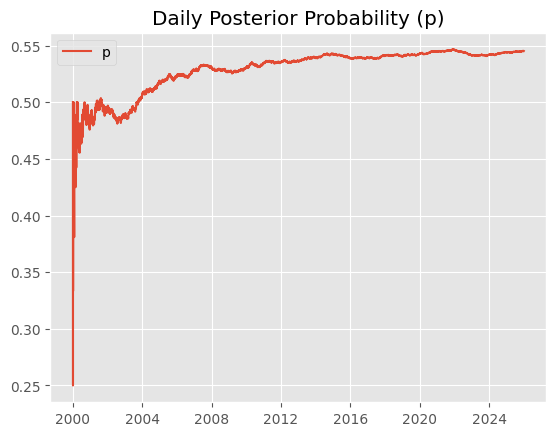

In [304]:
plt.plot(posteriors["probs"], label="p")
plt.title("Daily Posterior Probability (p)")
plt.legend()
plt.show()

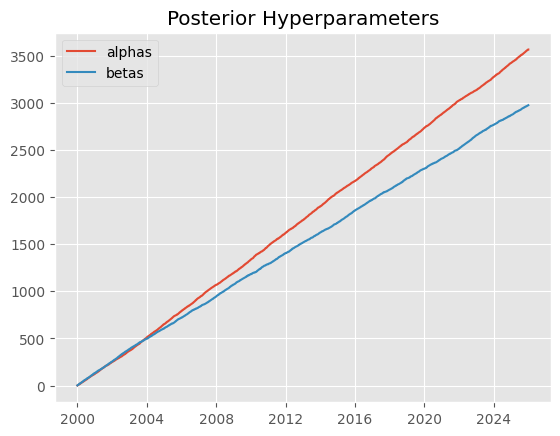

In [305]:
plt.plot(posteriors["alpha"], label="alphas")
plt.plot(posteriors["beta"], label="betas")
plt.title("Posterior Hyperparameters")
plt.legend()
plt.show()

In [306]:
y_true = data["Mt"]
y_prob = posteriors["probs"].shift(1).fillna(0.5)

# Prediction metrics
brier_score    = brier_score_loss(y_true, y_prob)
log_loss_score = log_loss(y_true, y_prob)

print(f"Brier:    {brier_score}")
print(f"Log-Loss: {log_loss_score}")

Brier:    0.2482523030499293
Log-Loss: 0.6896501688799895


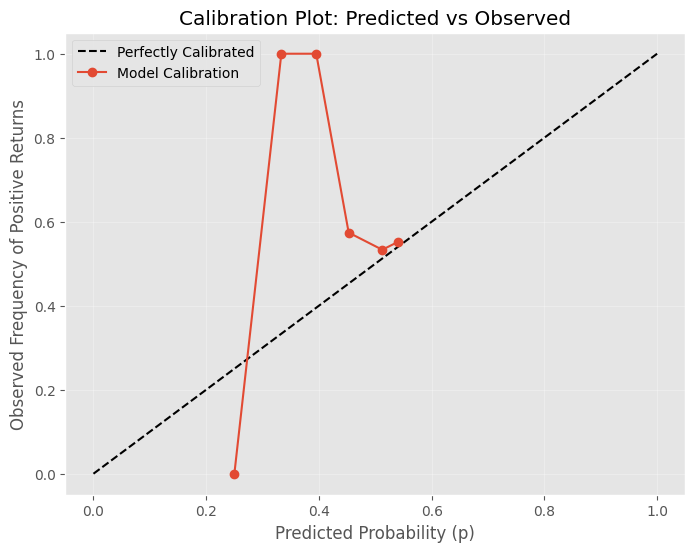

In [307]:
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=15, strategy='uniform')

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
ax.plot(prob_pred, prob_true, marker="o", label="Model Calibration")

ax.set_title("Calibration Plot: Predicted vs Observed")
ax.set_xlabel("Predicted Probability (p)")
ax.set_ylabel("Observed Frequency of Positive Returns")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

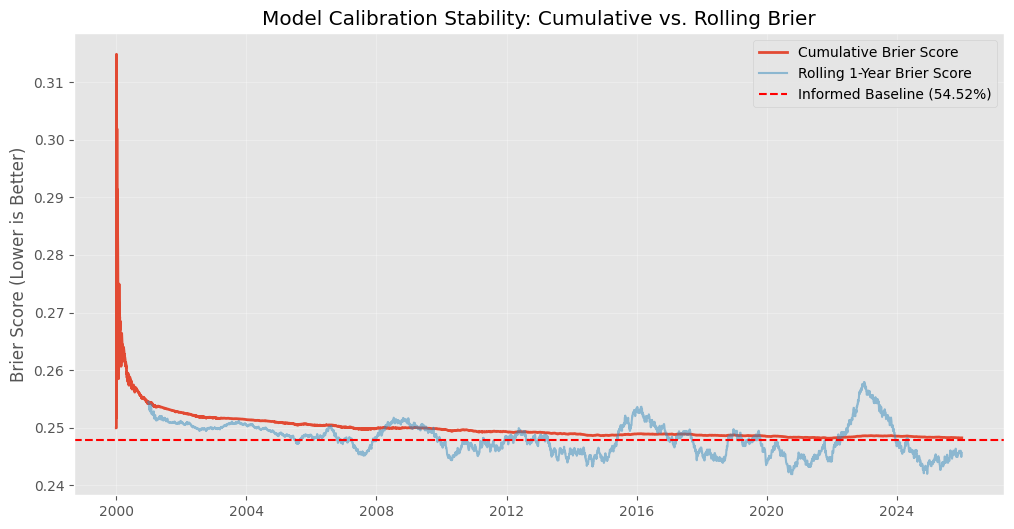

In [308]:
cum_brier = ((y_prob - y_true)**2).expanding().mean()
rolling_brier = ((y_prob - y_true)**2).rolling(window=252).mean()

# Baseline
base_rate = y_true.mean()
informed_baseline = base_rate * (1 - base_rate)

plt.figure(figsize=(12, 6))
plt.plot(cum_brier, label="Cumulative Brier Score", linewidth=2)
plt.plot(rolling_brier, label="Rolling 1-Year Brier Score", alpha=0.5)

plt.axhline(informed_baseline, color='red', linestyle='--',
            label=f"Informed Baseline ({base_rate:.2%})")

plt.title("Model Calibration Stability: Cumulative vs. Rolling Brier")
plt.ylabel("Brier Score (Lower is Better)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Below explores market regimes and predictions on longer time frames.

In [309]:
# Compute horizon returns
data["Rt_week"]  = data[TICKER].pct_change(WEEK)
data["Rt_month"] = data[TICKER].pct_change(MONTH)

# Compute horizon regimes
data["Mt_week"]  = (data["Rt_week"] > 0).astype(int)
data["Mt_month"] = (data["Rt_month"] > 0).astype(int)

In [310]:
# Set the initial priors
a_w, b_w = 1, 1
a_m, b_m = 1, 1

alphas_w, betas_w, probs_w = [], [], []
alphas_m, betas_m, probs_m = [], [], []

for i in range(len(data)):
    # Compute posterior probability
    p_w = a_w / (a_w + b_w)
    p_m = a_m / (a_m + b_m)

    # Update the priors (posterior hyperparameters)
    a_w += 1 if data["Mt_week"].iloc[i] == 1 else 0
    b_w += 1 if data["Mt_week"].iloc[i] == 0 else 0

    a_m += 1 if data["Mt_month"].iloc[i] == 1 else 0
    b_m += 1 if data["Mt_month"].iloc[i] == 0 else 0

    # Store
    alphas_w.append(a_w)
    betas_w.append(b_w)
    probs_w.append(p_w)

    alphas_m.append(a_m)
    betas_m.append(b_m)
    probs_m.append(p_m)

# Update the posterior results
posteriors["alpha_w"], posteriors["alpha_m"]  = alphas_w, alphas_m
posteriors["beta_w"], posteriors["beta_m"]    = betas_w, betas_m
posteriors["probs_w"], posteriors["probs_m"]  = probs_w, probs_m

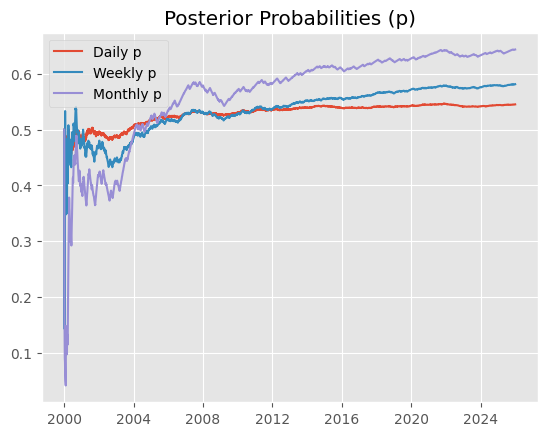

In [311]:
plt.plot(posteriors["probs"], label="Daily p")
plt.plot(posteriors["probs_w"], label="Weekly p")
plt.plot(posteriors["probs_m"], label="Monthly p")
plt.title("Posterior Probabilities (p)")
plt.legend()
plt.show()

In [312]:
y_true_w, y_true_m = data["Mt_week"], data["Mt_month"]
y_prob_w, y_prob_m = posteriors["probs_w"].shift(1).fillna(0.5), posteriors["probs_m"].shift(1).fillna(0.5)

# Prediction metrics
brier_score_w, brier_score_m = brier_score_loss(y_true_w, y_prob_w), brier_score_loss(y_true_m, y_prob_m)
log_loss_score_w, log_loss_score_m = log_loss(y_true_w, y_prob_w), log_loss(y_true_m, y_prob_m)

print(f"Brier (Week):     {brier_score_w}")
print(f"Log-Loss (Week):  {log_loss_score_w}")
print(f"Brier (Month):    {brier_score_m}")
print(f"Log-Loss (Month): {log_loss_score_m}")

Brier (Week):     0.24403372829312872
Log-Loss (Week):  0.6812431541057926
Brier (Month):    0.2299623799612478
Log-Loss (Month): 0.6528458177539053


## Part 2: Windowed Bayesian Updating
This section explores the limitations discussed in Part 1. The rolling windows are applied to $\alpha$ and $\beta$.

In [ ]:
# Constant adders for priors
ALPHA_PRIOR = 1
BETA_PRIOR  = 1

WINDOWS = [WEEK, MONTH, YEAR]

p_estimates = pd.DataFrame(columns=[WEEK, MONTH, YEAR])

# Process all windows
for w in WINDOWS:
    mt_window = data["Mt"].shift(1).rolling(window=w).sum()

    # Compute hyperparameters only on window
    a_rolling = mt_window + ALPHA_PRIOR
    b_rolling = (w - mt_window) + BETA_PRIOR

    # Signal inversion
    p_estimates[w] = 1 - (a_rolling / (a_rolling + b_rolling))

# Clean probability estimates
p_estimates.index = data.index

print(p_estimates.tail())

                 5         21        252
Date                                    
2025-12-22  0.571429  0.391304  0.429134
2025-12-23  0.428571  0.347826  0.425197
2025-12-24  0.285714  0.347826  0.421260
2025-12-26  0.142857  0.347826  0.421260
2025-12-29  0.285714  0.391304  0.425197


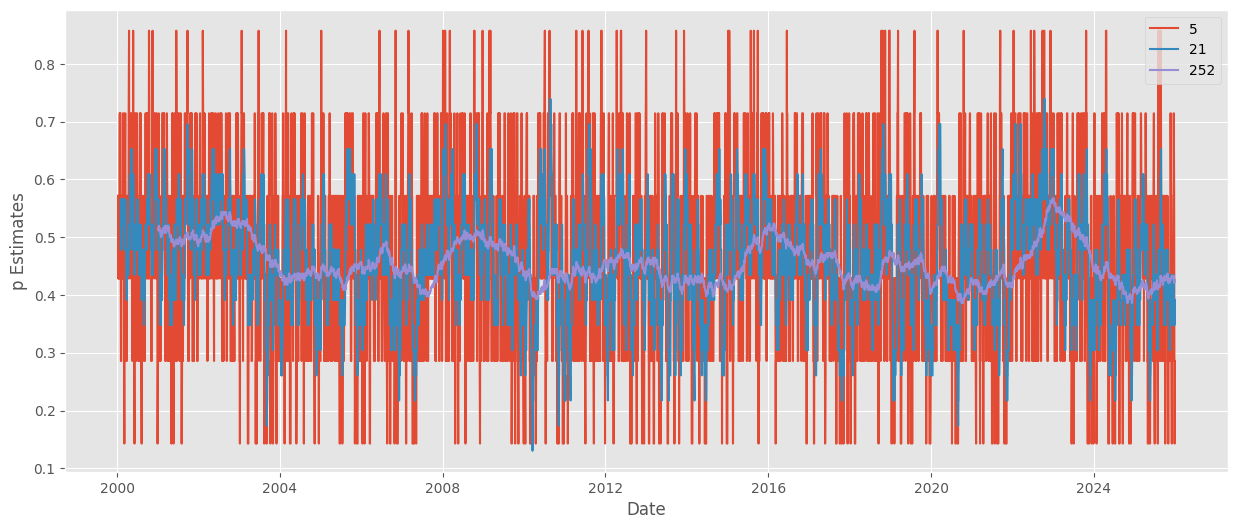

In [314]:
plt.figure(figsize=(15, 6))
plt.plot(p_estimates)
plt.xlabel("Date")
plt.ylabel("p Estimates")
plt.legend(p_estimates.columns)
plt.show()

In [315]:
performance_metrics = {}
y_true = data["Mt"]

for w in WINDOWS:
    # Align probability estimates
    valid_mask = p_estimates[w].notna()

    y = y_true[valid_mask]
    p = p_estimates.loc[valid_mask, w]

    # Brier score
    bs = ((p - y)**2).mean()

    # Log-loss
    p_clipped = p.clip(1e-15, 1 - 1e-15)
    ll = -(y * np.log(p_clipped) + (1 - y) * np.log(1 - p_clipped)).mean()

    performance_metrics[w] = {"Brier Score": bs, "Log-Loss": ll}

metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df)

     Brier Score  Log-Loss
5       0.273273  0.747754
21      0.262942  0.720661
252     0.258773  0.710845


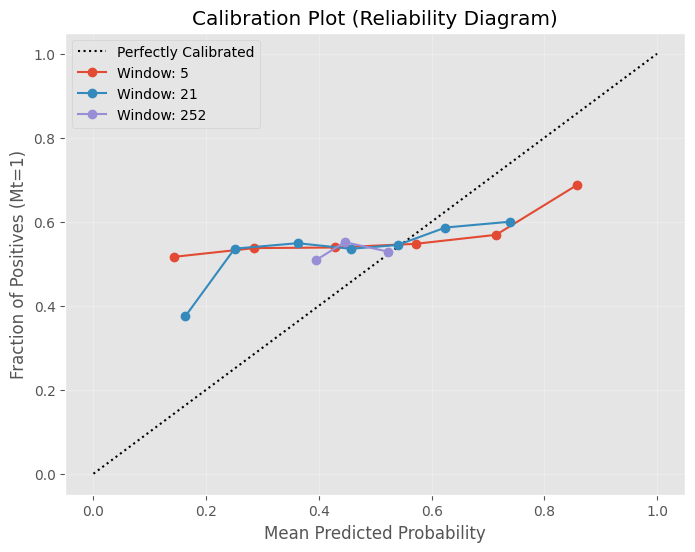

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Add the "Perfectly Calibrated" reference line
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")

for w in WINDOWS:
    # Filter NaNs for the specific window
    valid = p_estimates[w].notna()
    y = y_true[valid]
    p = p_estimates.loc[valid, w]

    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(y, p, n_bins=10, strategy='uniform')

    ax.plot(prob_pred, prob_true, marker='o', label=f'Window: {w}')

ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives (Mt=1)")
ax.set_title("Calibration Plot")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

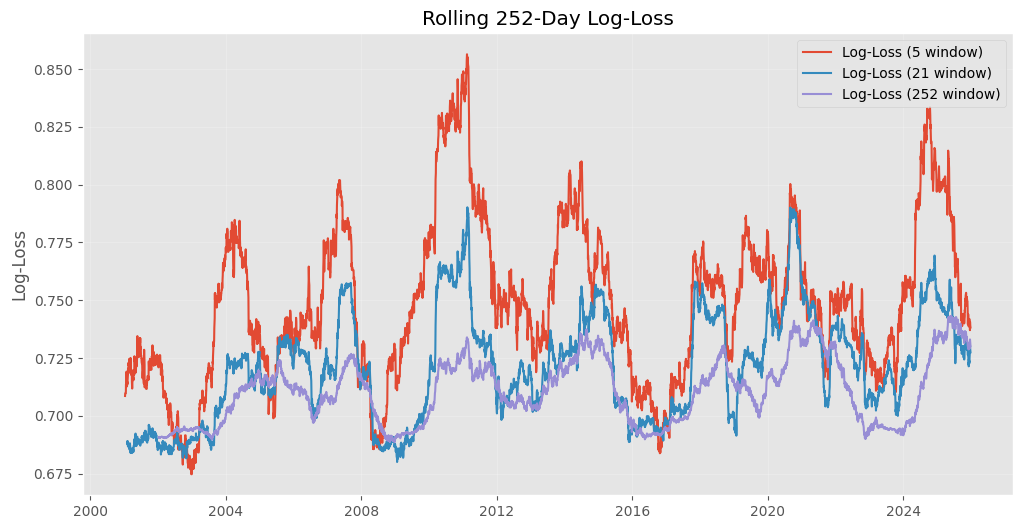

In [317]:
plt.figure(figsize=(12, 6))

for w in WINDOWS:
    valid = p_estimates[w].notna()
    y = y_true[valid]
    p = p_estimates.loc[valid, w].clip(1e-15, 1-1e-15)

    # Calculate point-wise log-loss
    pointwise_ll = -(y * np.log(p) + (1 - y) * np.log(1 - p))

    # Plot the rolling average of that loss
    rolling_ll = pointwise_ll.rolling(window=252).mean()
    plt.plot(rolling_ll, label=f'Log-Loss ({w} window)')

plt.title(f"Rolling {252}-Day Log-Loss")
plt.ylabel("Log-Loss")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()